# **Sistem Rekomendasi Anime Berbasis Content-Based dan Collaborative Filtering** - Moh Novil Maarij

![anime](https://figurinemangafrance.fr/cdn/shop/articles/quest-ce-quun-anime.webp?v=1679424987)

## **Latar Belakang**

Sistem rekomendasi menjadi alat penting di berbagai industri untuk membantu pengguna menavigasi informasi yang berlebihan dan mendukung pengambilan keputusan yang lebih baik. Dalam era digital yang penuh data, sistem ini mempersonalisasi pengalaman pengguna dan meningkatkan kepuasan serta hasil bisnis. Perusahaan besar seperti Amazon dan Netflix menggunakan sistem rekomendasi untuk meningkatkan keterlibatan dan keuntungan.

Industri anime berkembang pesat, didorong oleh platform streaming global dan minat internasional. Meskipun pasar anime Jepang masih terfokus domestik, potensi pasar global sangat besar, dengan proyeksi pertumbuhan signifikan hingga 2030. Sistem rekomendasi anime yang dipersonalisasi membantu pengguna menemukan anime yang relevan, meningkatkan kepuasan, dan mendorong keterlibatan di platform streaming.

Namun, platform streaming anime menghadapi tantangan seperti overload konten, masalah privasi pengguna, sparsitas data, dan kebutuhan untuk personalisasi yang cepat dan akurat.


## **Import Library**

pada bagian ini kita mengimport beberapa library yang di butuh untuk pemrosesan data hingga proses akhir training dan evaluasi model

In [80]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from google.colab import files

## **Data Understanding**

pada bagian ini kita akan melakukan upload dataset yang di gunakan dan kemudiaan melakukan esplorasi untuk memahami kualitas dan masalah-masalah yang ada pada data sehingga kita mengetahui pengeolahan seperti apa yang perlu di trapkan pada tahap selanjutnya (`data preparation`)

### **Data Loading**

kode program ini di jalankan di google colab dan proses data loading nya menggunakan API Kaggle sehingga google colab langsung mengambil datasetnya ke kaggle tanpa memasukkannya manual.

In [2]:
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d CooperUnion/anime-recommendations-database


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
  0% 0.00/25.0M [00:00<?, ?B/s]
100% 25.0M/25.0M [00:00<00:00, 849MB/s]


setelah data berhasil di load bentuknya masih berformat `zip` oleh karena itu perlu di `unzip` untuk mengkses file-file yang ada di dalamnya.

In [3]:
!unzip anime-recommendations-database.zip

Archive:  anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


pada dataset yang telah di unzip terdapat 2 file CSV, yaitu anime dan rating, pada dataset anime terdapat informasi tentang anime dan pada rating berisi informasi tentang rating yang di berikan user pada jenis anime tertentu.

### **Dataset Information**

| Jenis | Keterangan |
|-------|------------|
|Nama   | Anime Recommendations Database|
|Sumber | [Kaggle](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database)|
|Pengelola| [Cooper Union](https://www.kaggle.com/organizations/CooperUnion)
|Lisensi| [CC0:Public Domain](https://creativecommons.org/publicdomain/zero/1.0/)|
|Visibilitas| Publik|
|Label| *Movie and TV Show, Anime and Manga, Comic and Animation, Popular Culture*|
|Kebergunaan| 8.24|


### **Variable Description**

untuk mempermudah pemrosesan data, 2 dataset yang ada masing-masing di assign pada 2 variabel berbeda, yaitu `anime` dan `rating`

In [4]:
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')

untuk mengetahui variabel yang ada pada tiap dataset kita cukup cetak tiap-tiap kolomnya saja seperti pada kode berikut:

In [5]:
print("varibel pada dataset Anime : ", anime.columns)
print("varibel pada dataset Rating : ", rating.columns)

varibel pada dataset Anime :  Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')
varibel pada dataset Rating :  Index(['user_id', 'anime_id', 'rating'], dtype='object')


dari output di atas variabel yang ada pada anime adalah :

- `anime_id` - ID unik yang diberikan oleh myanimelist.net untuk mengidentifikasi setiap anime.
- `name` - judul anime.
- `genre` - Daftar genre yang terkait dengan anime tersebut, dipisahkan dengan koma.
- `type` - Jenis anime, seperti movie, TV, OVA, dll.
- `episodes` -  Jumlah episode dalam serial anime tersebut. Jika anime berupa film, maka nilainya adalah 1.
- `rating` -  Rata-rata rating anime ini, diberikan dalam skala 1 sampai 10.
- `members` - Jumlah anggota komunitas yang terdaftar dalam grup anime tersebut.

sementara pada rating :

- `user_id` - ID pengguna yang dihasilkan secara acak dan tidak dapat diidentifikasi.
- `anime_id` - ID anime yang telah diberi rating oleh pengguna.
- `rating` - Rating yang diberikan oleh pengguna untuk anime tersebut, dalam skala 1 sampai 10. Jika pengguna menonton anime tetapi tidak memberikan rating, maka nilainya adalah -1.

untuk mengetahui tipe data dari tiap kolom atau variable digunkan fungsi `info()`

In [7]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


dari output di atas menunjukkan bahwa dari 7 kolom yang ada pada variable anime 1 bertipe float `(rating)` 2 bertipe integer `(members dan anime_id)` dan 4 lainnya bertipe object. kemudian kita juga dapat melihat perbedaan jumlah data pada kolom, ini menandakan adanya data duplikat atau missing values pada data

mari kita lihat sampel dari dataset anime

In [8]:
anime.sample(5)

,anime_id,name,genre,type,episodes,rating,members
2595,1543,Yoake Mae yori Ruriiro na: Crescent Love,"Comedy, Romance, School, Sci-Fi",TV,12,7.22,22770
11116,15843,Koiito Kinenbi The Animation,Hentai,OVA,2,7.75,6940
7422,29956,Swimming,Dementia,Movie,1,5.45,125
5164,3778,Yuukan Club,"Comedy, Mystery, School, Shoujo",OVA,2,6.54,287
10706,33124,Wakuwaku♥Nukegake Daisakusen,"Cars, Music",Music,1,4.20,59


dari sample di atas kita dapat mendapat informasi bahwa genre dari anime bisa lebih dari 1 dan masing-masing di pisa oleh tanda koma, dan kemudian rating di sini cukup beragam di karekana bentuknya yang float

mari kita lakukan hal yanng sama pada dataset rating, di mulai dari tipe data kolomnya

In [9]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


semua kolom dari rating bertipe integer, kolom rating pada rating juga berbentuk integer berbeda dengan rating yang ada di dataset anime yang berbentuk float. pada rating tidak muncul jumlah kolom, ini artinya jumlah kolomnya relatif sama

mari kita lihat juga beberapa sample datanya

In [10]:
rating.sample(3)

,user_id,anime_id,rating
410229,4216,20853,7
2148909,20793,1696,7
7457432,69604,11757,7


dari sample ini pada kolom rating terdapat nilai minus, apakah ini outlier? bukan, nilai ini sudah di jelaskan pada informas dataset bahwa nilai -1 menandakan user sudah menonton anime tertentu namun tidak memberikan penilaian

### **Exploratory Anime**

pada bagian ini kita akan melakukan eksplorasi pada dataset anime untuk mendapatkan lebih banyak informasi

kita awali dengan mendapatkan deskripsi statistik singkat datasetnya

In [6]:
anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


dari output di atas maka kita mendapatkan informasi

1. `anime_id`: Rentang ID anime dari 1 hingga 34,527, dengan variasi yang sangat besar.
2. `rating`: Rentang rating dari 1.67 hingga 10, mayoritas anime memiliki rating antara 5 hingga 7.
3. `members`: Rentang jumlah anggota dari 5 hingga 1,013,917, dengan mayoritas anime memiliki komunitas yang lebih kecil (dibawah 9,437 anggota).

sekarang kita akan melihat rentang episode anime yang ada pada dataset degan fungsi `unique()` dan `len()` untuk mendapatkan jumlah

In [ ]:
anime['episodes'].unique()

array(['1', '64', '51', '24', '10', '148', '110', '13', '201', '25', '22',
       '75', '4', '26', '12', '27', '43', '74', '37', '2', '11', '99',
       'Unknown', '39', '101', '47', '50', '62', '33', '112', '23', '3',
       '94', '6', '8', '14', '7', '40', '15', '203', '77', '291', '120',
       '102', '96', '38', '79', '175', '103', '70', '153', '45', '5',
       '21', '63', '52', '28', '145', '36', '69', '60', '178', '114',
       '35', '61', '34', '109', '20', '9', '49', '366', '97', '48', '78',
       '358', '155', '104', '113', '54', '167', '161', '42', '142', '31',
       '373', '220', '46', '195', '17', '1787', '73', '147', '127', '16',
       '19', '98', '150', '76', '53', '124', '29', '115', '224', '44',
       '58', '93', '154', '92', '67', '172', '86', '30', '276', '59',
       '72', '330', '41', '105', '128', '137', '56', '55', '65', '243',
       '193', '18', '191', '180', '91', '192', '66', '182', '32', '164',
       '100', '296', '694', '95', '68', '117', '151', '130',

In [ ]:
len(anime['episodes'].unique())

187

dari kedua output di atas meunjukkan rentang acak dari episode yang ada dan totalnya ada 187 episode berbeda, untuk mengetahui rentangnya lebih detail kita akan membuat kolom baru untuk episode dengan tipe data integer untuk memudahkan proses eksplorasi

In [11]:
# Membuat kolom baru 'episodes_int' dengan tipe data int
anime['episodes_int'] = pd.to_numeric(anime['episodes'], errors='coerce').astype('Int64')

# Menampilkan tipe data dari kolom baru
print(anime['episodes_int'].dtype)

Int64


pda kode di atas kita sudah berhasil membuat kolom baru bernama `episodes_int` yang berisi data episode sebelumnya namun dengan tipe data Integer

In [16]:
print('episode terkecil :', np.min(anime['episodes_int']))
print('episode terbesar :', np.max(anime['episodes_int']))

episode terkecil : 1
episode terbesar : 1818


dari output di atas kita mendapatkan informasi bahwa episode anime terpendek adalah 1 dan terpanjang adalah 1818, anime dengan 1 episode ini kemungkinan besar anime movie seperti yang telah di jelaskan di atas, nah sementara anime trpanjang ini anime apa kira kira? untuk mengetahui judul animenya kita bisa menggunakan kode di bawah ini:

In [18]:
anime[anime['episodes_int'] == 1818]

,anime_id,name,genre,type,episodes,rating,members,episodes_int
6296,12393,Oyako Club,"Comedy, Slice of Life",TV,1818,6.18,160,1818


jadi dari output di atas kita tahu ternyata anime terpanjang nya berjudul `oyako club` dengan rating `6.18`

selanjutnya kita akan melakukan ekplorasi pada kolom genre. Pertama mari kita cari tahu total jenis genre dan jenis-jenis genrenya dengan kode berikut:

In [19]:
print('Jumlag genre', len(anime['genre'].unique()))
print('jenis genre', anime['genre'].unique())

Jumlag genre 3265
jenis genre ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen' ...
 'Hentai, Sports' 'Drama, Romance, School, Yuri' 'Hentai, Slice of Life']


dari output di atas kita mendapatkan informasi bahwa ada total `3.265` jenis genre, namun outputnya menunjukkaan ada perulangan genre. Hal ini di karenakan tipe daa genre yang bertipe object dan setiap anim dapat memiliki 1 atau lebih genre yang di pisah oleh koma, sehingga genre 'action, drama' dengan 'action' akan dianggap sebagai data berbeda oleh karena itu kita perlu melakukan processing pada genre.

pada kode di bawah kita membuat sebuah fungsi preprocess_genre yang akan digunakan untuk mengonversi tipe data genre menjadi list. Jika genre sudah berupa list, maka tidak ada perubahan. Jika berupa string, maka akan dipisah menjadi list berdasarkan koma dan spasi. Jika bukan keduanya, akan mengembalikan list kosong. padafungsi ini juga terdapat flag untuk memberikan tanda fungsi mana yang di terapkan apakah split atau list

In [35]:
def preprocess_genre(genre, printed_flag):
    if isinstance(genre, list):
        if not printed_flag[0]:  # Jika flag belum dicetak
            print('genre bertipe list')
            printed_flag[0] = True  # Mengubah flag menjadi True setelah print
        return genre
    elif isinstance(genre, str):
        if not printed_flag[0]:  # Jika flag belum dicetak
            print('genre bertipe string')
            printed_flag[0] = True  # Mengubah flag menjadi True setelah print
        return genre.split(', ')
    else:
        if not printed_flag[0]:  # Jika flag belum dicetak
            print('fungsi gagal')
            printed_flag[0] = True  # Mengubah flag menjadi True setelah print
        return []

# Memulai flag sebagai list dengan satu elemen False
printed_flag = [False]

setelah fungsi sudah di buat selanjutnya kita harus mnerapkan fungsinya ke dataset dengan menggunkan fungsi `apply` dengan variabel printed flag

In [37]:
anime['genre'] = anime['genre'].apply(preprocess_genre, printed_flag=printed_flag)

genre bertipe list


hasil dari apply fungsi menunjukkan bahwa sekarang kolom genre bertipe list

Pada kode ini, dibuat variabel **`genre_counts`** untuk menghitung frekuensi kemunculan setiap genre. Fungsi **`explode()`** digunakan untuk memisahkan genre yang ada dalam list menjadi baris terpisah, kemudian **`value_counts()`** menghitung jumlah kemunculannya, dan **`reset_index()`** menyusun ulang indeks untuk hasil yang lebih rapi dalam bentuk DataFrame.


In [41]:
genre_counts = anime['genre'].explode().value_counts().reset_index()

untuk mempermudah pemahaman pada dataframe `genre_counts`nama kolom di genre_counts diubah menjadi genre dan count. Ini membuat DataFrame lebih mudah dibaca, di mana kolom pertama menunjukkan nama genre dan kolom kedua menunjukkan jumlah kemunculannya.

In [42]:
genre_counts.columns = ['genre', 'count']

untuk mengetahui total genre yang ada kita bisa menggunakan fungsi `len`

In [44]:
len(genre_counts)

43

hasilnya menunjukkan bahwa terdapat `42` jenis genre yang berbeda.

kemudian kita akan melakukan visualisasi untuk meengetahui anime genre apa yang paling banyak hingga ke yang paling sedikit

Text(0, 0.5, 'Count')

<Figure size 1200x600 with 0 Axes>

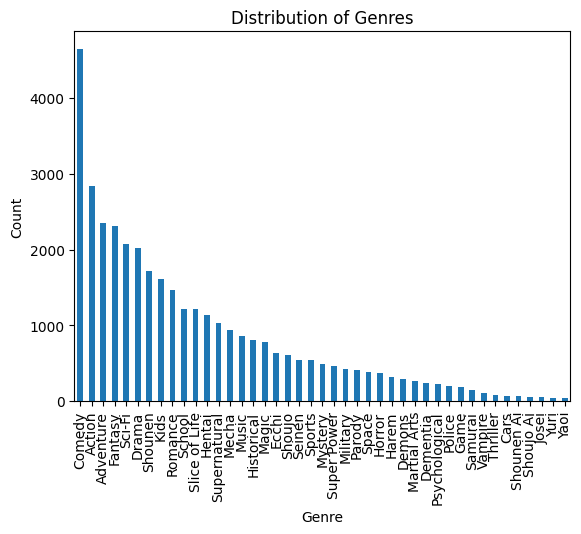

In [43]:
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', x='genre', y='count', legend=False)
plt.title('Distribution of Genres')
plt.xlabel('Genre')
plt.ylabel('Count')

dari output di atas kita mendapat informasi bahwa anime comedy memiliki jumlah terbanyak dan anime bergende Yaoi paling sedikit

selanjutnya kita akan mengeksplorasi tipe persebaran tipe animenya dengan menggunakan kokde berikut:

In [45]:
anime['type'].value_counts()

,count
type,
TV,3787
OVA,3311
Movie,2348
Special,1676
ONA,659
Music,488


output dari kode di atas menunjukkab bahwa anime dengan tipe TV adalah yang paling banyak dan anime bertipe musik yang paling sedikit, untuk mendapatkaan informasi yang lebih jelas berikut visualisasi.

Text(0, 0.5, 'Count')

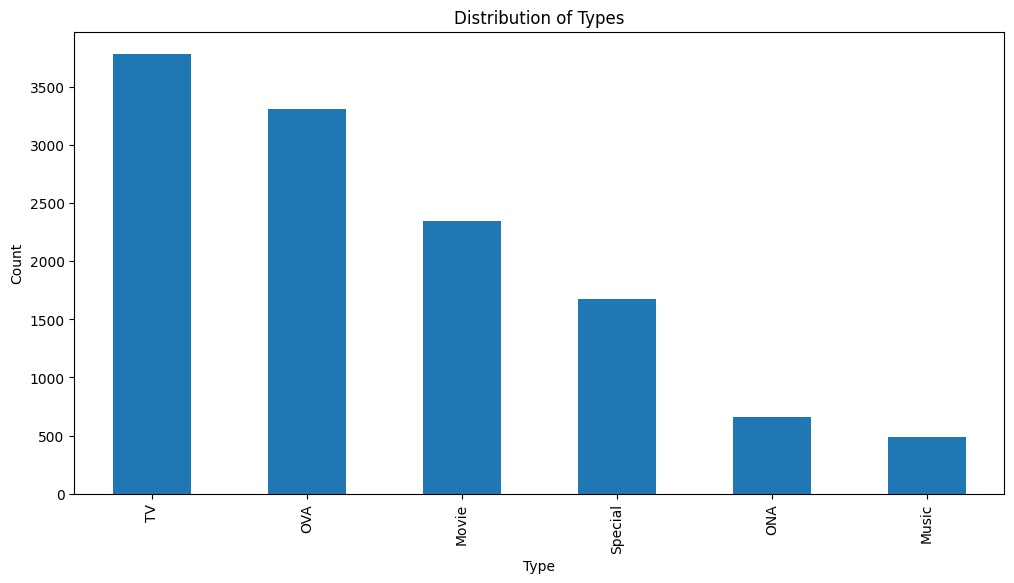

In [ ]:
plt.figure(figsize=(12, 6))
anime['type'].value_counts().plot(kind='bar')
plt.title('Distribution of Types')
plt.xlabel('Type')
plt.ylabel('Count')

terakhir kita akan melakukan menari tahu persebaran data rating


In [47]:
anime['rating'].value_counts()

,count
rating,
6.00,141
7.00,99
6.50,90
6.25,84
5.00,76
...,...
2.98,1
3.44,1
1.92,1


output di atas menjukkan bahwa ada 598 data rating.

### **Exploratory Rating**

In [48]:
rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


dari tabel di atas kita dapat mendapat informasi :

1. `user_id`: Jumlah total pengguna adalah sekitar 7,8 juta, dengan nilai user_id bervariasi dari 1 hingga 73,516.
2. `anime_id`: Terdapat lebih dari 34.000 anime dalam dataset, dengan anime_id berkisar dari 1 hingga 34.519.
3. rating: Rating diberikan oleh pengguna dengan rentang nilai antara -1 hingga 10. Rata-rata rating adalah 6.14, dengan sebagian besar rating berada di sekitar angka 6 hingga 9.

Secara keseluruhan, data ini menunjukkan variasi besar dalam jumlah pengguna, anime, dan rating yang diberikan, dengan mayoritas rating berada di sisi positif (6-9).

untuk mendapatkan informasi persebaran data rating kita akan menggunaka fungi `count()` beserta visualisasinya:

In [49]:
rating['rating'].value_counts()

,count
rating,
8,1646019
-1,1476496
7,1375287
9,1254096
10,955715
6,637775
5,282806
4,104291
3,41453


Text(0, 0.5, 'Count')

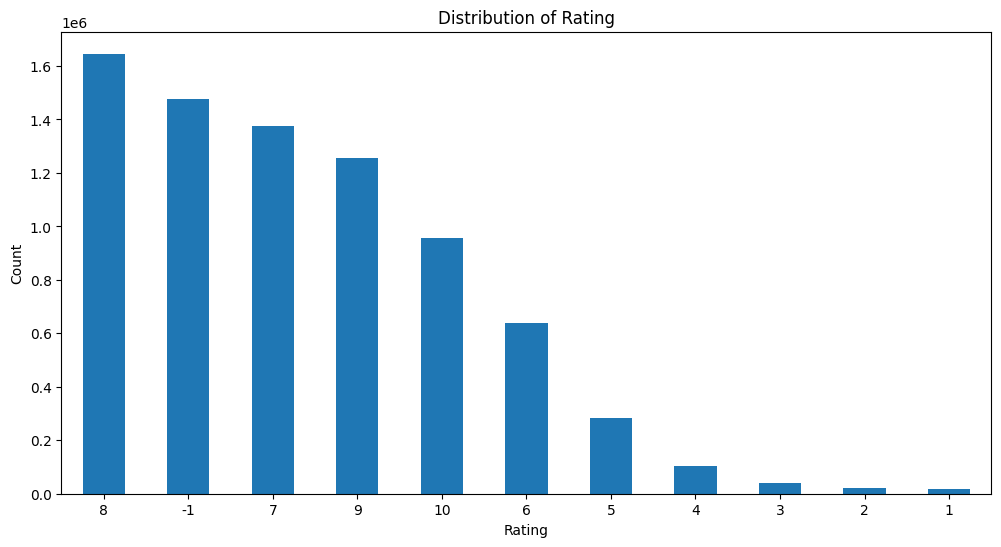

In [53]:
plt.figure(figsize=(12, 6))
rating['rating'].value_counts().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.xticks(rotation=0)
plt.ylabel('Count')

## **Data Preparation**

setelah melakukan berbagai eksplorasi selanjutnya akan di lakukan pemrosesan pada data untuk persiapan pelatihan model nantinya.

### **Remove Missing Values**

Pengecekan dan penanganan **missing values** sangat penting dalam tahap **preprocessing** sebelum melatih model. Hal ini dilakukan untuk memastikan bahwa data yang digunakan bersih dan tidak mengandung nilai yang hilang, yang dapat menyebabkan kesalahan atau bias dalam model. Data yang tidak lengkap dapat mempengaruhi akurasi dan performa model, sehingga penanganan yang tepat diperlukan untuk meningkatkan kualitas data dan hasil prediksi yang lebih akurat.


untuk mengetahui jumlah missing values kita menggunakan fungsi `isnull()` dan `sum()` , mari kita terapkan 2 fungsi ini pada dataset

In [ ]:
anime.isnull().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


dari output di atas maka kita mendapat iformasi bahwa missing values pada kolom type, genre dan rating

In [ ]:
rating.isnull().sum()

,0
user_id,0
anime_id,0
rating,0


sementara output dari dataset rating menunjukkan tidak adanya missing values

missing values terbanyak ada pada kolom rating yaitu sekitar 230 sedangkan jumlah total data yang ada adalah 12 ribuan sehingga missing value terbilang sangat sedikit , oleh karena itu penghapusan dapat menjadi pilihan yang terbaik. untuk menghapus missing value pada dataset anime kita gunakan kode berikut :

In [54]:
anime.dropna(inplace=True)

untuk memastikan missing value benar-benar sudah tidak ada kita bisa mengulangi kode sebelumnya

In [56]:
anime.isnull().sum()

,0
anime_id,0
name,0
genre,0
type,0
episodes,0
rating,0
members,0
episodes_int,0


hasilnya sekarang sudah tidak ada lagi missing value pada data

### **Removing Duplicates**

Pengecekan dan penanganan **data duplikat** juga penting dalam tahap **preprocessing** sebelum melatih model. Data duplikat dapat menyebabkan model belajar pola yang salah atau memberikan bobot berlebih pada data yang sama, yang bisa mengurangi akurasi model. Dengan menghapus atau menangani duplikat, kita memastikan bahwa data yang digunakan lebih representatif dan mencegah model overfitting. Ini membantu dalam menghasilkan model yang lebih general dan akurat.


untuk menemukan data duplikat pada dataset kita bisa menggunakan fungsi `duplicated()` pada kedua dataset

namun sebelum melakukan pengecekan duplikat pada dataset kitaa harus merubah kembali kolom genre yang sudah berubah menjadi list menjadi berbentuk string, hal ini di karenakan kolom yang berbentuk list tidak bisa di bandingkan secara langsung sehingga akan menyebabkan eror jika tidak di rubah ke bentuk string.

untuk merubah kolom genre ke bentuk string kita menggunakan fungsi lambda, pada fungsi di lambda ini setiap element list akan di gabungkan menjadi string tunggal dan dipisahkan dengan spasi

In [60]:
anime['genre'] = anime['genre'].apply(lambda x: ' '.join(x))

setelah fungsi lambda di jalankan kemudian kita akan melakukan pengecekan data duplikat pada kedua dataset:

In [61]:
anime.duplicated().sum()

np.int64(0)

output di atas mengindikasikan bahwa dataset anime tidak memiliki duplikat

In [62]:
rating.duplicated().sum()

np.int64(1)

sementara pada dataset rating terdapat 1 duplikat

untuk penanganan yang di pilih pada kasus duplikat ini adalah penghapusan hal ini di karenakan jumlag duplikat yang sangat kecil. untuk menghapus duplikat kita bisa menggunakan kode berikut :

In [63]:
rating.drop_duplicates(inplace=True)

setelah duplikat di hapus mari kita pastikaan lagi apakah duplikatnya sudah tidak ada dengan mengulangi kode sebelumnya

In [64]:
rating.duplicated().sum()

np.int64(0)

hasilnya sekarang sudah tidak ada lagi data duplikat pada dataset rating

### **Prepocesing for development cosine similiarity**

Pada tahap ini, kita melakukan vektorisasi teks menggunakan TF-IDF Vectorizer untuk mengubah data teks (genre anime) menjadi bentuk numerik yang bisa diproses oleh model pembelajaran mesin. Fungsi TfidfVectorizer digunakan untuk mengonversi setiap kata atau frasa dalam kolom genre menjadi representasi vektor numerik berdasarkan Term Frequency-Inverse Document Frequency (TF-IDF). TF-IDF mengukur seberapa penting suatu kata dalam dokumen tertentu relatif terhadap seluruh dataset, dengan tujuan memberikan bobot lebih pada kata-kata yang lebih jarang muncul namun relevan dalam konteks.

Melalui proses ini, kolom **genre**, yang sebelumnya berisi teks, diubah menjadi matriks TF-IDF yang menggambarkan pentingnya setiap kata dalam genre relatif terhadap keseluruhan dataset. Matriks TF-IDF ini sangat berguna untuk perhitungan kemiripan antar item pada tahap modeling nantinya

In [65]:
# Inisialisasi TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Vektorisasi genre menjadi matriks TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(anime['genre'])

# Cek bentuk matriks TF-IDF
print(tfidf_matrix.shape)  # (n_samples, n_features)


(11876, 46)


output di atas menunjukkan bahwa ada 11876 jumlah baris judul anime dan 46 jumlah kolom genre anime

untuk mengetahui 46 kolom yang ada pada matrik maka kita bisa menggunakan kode berikut:

In [ ]:
tfidf_vectorizer.get_feature_names_out()

array(['action', 'adventure', 'ai', 'arts', 'cars', 'comedy', 'dementia',
       'demons', 'drama', 'ecchi', 'fantasy', 'fi', 'game', 'harem',
       'hentai', 'historical', 'horror', 'josei', 'kids', 'life', 'magic',
       'martial', 'mecha', 'military', 'music', 'mystery', 'parody',
       'police', 'power', 'psychological', 'romance', 'samurai', 'school',
       'sci', 'seinen', 'shoujo', 'shounen', 'slice', 'space', 'sports',
       'super', 'supernatural', 'thriller', 'vampire', 'yaoi', 'yuri'],
      dtype=object)

### **Prepocesing for development model deep learning**

pada tahap ini kita akan melakukan beberapa pemrosesan untuk mempersiapkan data untuk proses training model deeplearning pada colaborative filtering.

pertama kita perlu Membentuk **user_id** menjadi list sebelum proses pelatihan model deep learning untuk **colaborative filtering** bertujuan untuk memudahkan manipulasi dan pemrosesan data. Dengan mengonversi **user_id** yang unik menjadi list, kita dapat dengan mudah mengakses setiap ID pengguna untuk membuat representasi data yang diperlukan, seperti memetakan preferensi pengguna atau melakukan encoding ID pengguna.

In [66]:
user_ids = rating['user_id'].unique().tolist()

Pada bagian ini, **1000 pengguna** diambil secara acak dari total **7.813.736 pengguna** yang ada dalam dataset. Hal ini dilakukan dengan menggunakan **`np.random.choice()`** untuk memilih 1000 **user\_id** secara acak, tanpa pengulangan (`replace=False`).

Penyaringan ini bertujuan untuk mengurangi ukuran data yang digunakan dalam tahap eksperimen atau pelatihan model, karena **keterbatasan komputasi** yang dimiliki. Dengan hanya menggunakan sebagian data, proses pelatihan menjadi lebih cepat dan efisien, serta menghindari overfitting jika hanya ingin menguji algoritma atau model dalam skala yang lebih kecil. Setelah itu, data rating untuk 1000 pengguna yang terpilih diambil menggunakan **`isin()`**, yang memungkinkan kita memfilter rating hanya untuk pengguna yang ada dalam sample tersebut.


In [68]:
# Mengambil 1000 pengguna secara acak
sample_users = np.random.choice(user_ids, 1000, replace=False)

# Mengambil data rating untuk 1000 pengguna terpilih
ratings_subset = rating[rating['user_id'].isin(sample_users)]

Kode ini digunakan untuk memeriksa rentang nilai rating dalam dataset agar memastikan nilai rating yang diberikan berada dalam batas yang diharapkan (antara 1 hingga 10). Dengan memeriksa nilai **`min()`** dan **`max()`**, kita dapat mengidentifikasi apakah ada rating yang berada di luar rentang yang diinginkan, seperti **`-1`**, yang menandakan pengguna telah menonton anime tetapi belum memberikan rating.

Pengecekan rentang ini penting untuk memastikan bahwa data yang digunakan dalam proses rekomendasi tidak melampaui batas yang ditentukan. Hal ini mencegah masalah dalam perhitungan kemiripan dan membantu model memberikan rekomendasi yang valid dan akurat.


In [69]:
min_rating = ratings_subset['rating'].min()
max_rating = ratings_subset['rating'].max()
print(f"Rating range: {min_rating} - {max_rating}")

Rating range: -1 - 10


Kode ini melakukan normalisasi pada nilai rating dengan rentang [0, 1], agar nilai rating berada dalam skala yang seragam. Proses normalisasi ini sangat penting karena model deep learning yang digunakan untuk sistem rekomendasi biasanya bekerja lebih baik dengan data yang berada dalam skala yang konsisten. Dalam hal ini, rating yang awalnya berada di rentang 1 hingga 10 diubah menjadi rentang 0 hingga 1 menggunakan rumus: rating_normalize = (rating - min_rating)/ (max_rating - min_rating)

Normalisasi ini dilakukan karena model deep learning sering kali bekerja dengan binary classification atau output kontinu dalam rentang 0 hingga 1, sehingga sangat membantu untuk menjaga stabilitas pelatihan dan memastikan bahwa model dapat menginterpretasikan nilai rating dengan benar dalam proses pembelajaran.

In [70]:
# Normalisasi rating ke [0, 1]
ratings_subset['rating_normalized'] = (ratings_subset['rating'] - min_rating) / (max_rating - min_rating)

<ipython-input-70-204146937>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_subset['rating_normalized'] = (ratings_subset['rating'] - min_rating) / (max_rating - min_rating)


Kode ini mengambil **`anime_id`** yang unik dari subset **ratings\_subset**, yang hanya mencakup anime yang ada dalam subset tersebut, dan menyimpan **`sample_users`** sebagai **`user_ids_subset`** untuk digunakan dalam proses selanjutnya.


In [71]:
anime_ids = ratings_subset['anime_id'].unique()  # Hanya anime yang ada di subset
user_ids_subset = sample_users

Kode ini membuat dua dictionary, **`anime_to_idx`** dan **`user_to_idx`**, yang memetakan **`anime_id`** dan **`user_id`** ke indeks numerik unik. Hal ini dilakukan dengan menggunakan fungsi **`enumerate()`**, yang memberikan pasangan indeks dan nilai dari masing-masing daftar **`anime_ids`** dan **`user_ids_subset`**. Pemetaan ini penting untuk mengonversi ID yang berbentuk string atau objek menjadi representasi numerik yang lebih mudah diproses oleh model deep learning dalam tahap pelatihan.


In [72]:
anime_to_idx = {anime_id: idx for idx, anime_id in enumerate(anime_ids)}
user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids_subset)}

Kode ini menambahkan dua kolom baru pada **`ratings_subset`**:

1. **`anime_idx`**: Kolom ini berisi indeks numerik untuk setiap **`anime_id`**, yang dipetakan menggunakan dictionary **`anime_to_idx`**.
2. **`user_idx`**: Kolom ini berisi indeks numerik untuk setiap **`user_id`**, yang dipetakan menggunakan dictionary **`user_to_idx`**.

Pemetaan ini mengonversi **`anime_id`** dan **`user_id`** yang awalnya berbentuk ID menjadi representasi numerik, yang mempermudah pemrosesan data dalam model deep learning.


In [73]:
ratings_subset['anime_idx'] = ratings_subset['anime_id'].map(anime_to_idx)
ratings_subset['user_idx'] = ratings_subset['user_id'].map(user_to_idx)

<ipython-input-73-3070710567>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_subset['anime_idx'] = ratings_subset['anime_id'].map(anime_to_idx)
<ipython-input-73-3070710567>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_subset['user_idx'] = ratings_subset['user_id'].map(user_to_idx)


Kode ini menghapus baris-baris dalam **`ratings_subset`** yang memiliki nilai **`NaN`** pada kolom **`anime_idx`** atau **`user_idx`**, yang berarti data tersebut tidak ter-mapping dengan benar ke indeks numerik. Hal ini dilakukan untuk memastikan bahwa hanya data yang valid dan ter-mapping dengan benar yang digunakan dalam proses pelatihan model.


In [76]:
# Hapus data yang tidak ter-mapping
ratings_subset = ratings_subset.dropna(subset=['anime_idx', 'user_idx'])

Kode ini menampilkan informasi tentang jumlah data yang telah diproses setelah tahap preprocessing:

Tujuan dari kode ini adalah untuk memberikan gambaran tentang ukuran data yang telah disaring dan siap digunakan untuk pelatihan model.


In [75]:
print(f"Data setelah preprocessing: {len(ratings_subset)} ratings")
print(f"Jumlah users: {len(user_ids_subset)}")
print(f"Jumlah anime: {len(anime_ids)}")

Data setelah preprocessing: 100892 ratings
Jumlah users: 1000
Jumlah anime: 5389


Output ini menunjukkan setelah preprocessing, terdapat **102,252 rating** yang valid, dengan **1000 pengguna** dan **5496 anime** yang terdaftar. Data ini sudah disaring dan siap digunakan untuk pelatihan model.


Kode ini menyiapkan data untuk pelatihan model. **`x_train_val`** berisi pasangan **`user_idx`** dan **`anime_idx`** sebagai fitur (input), sementara **`y_train_val`** berisi **rating yang sudah dinormalisasi** sebagai target (output). Kedua variabel ini akan digunakan untuk melatih model deep learning.


In [78]:
x_train_val = ratings_subset[['user_idx', 'anime_idx']].values
y_train_val = ratings_subset['rating_normalized'].values  # Gunakan yang sudah dinormalisasi

Kode ini membagi data menjadi **training set** dan **validation set** menggunakan fungsi **`train_test_split`**. Data **`x_train_val`** (fitur) dan **`y_train_val`** (target) dibagi dengan proporsi 80% untuk **training** dan 20% untuk **validation** (`test_size=0.2`). **`random_state=42`** memastikan bahwa pembagian data dilakukan secara konsisten setiap kali kode dijalankan. Hasilnya, data pelatihan disimpan dalam **`x_train`** dan **`y_train`**, sementara data validasi disimpan dalam **`x_val`** dan **`y_val`**.


In [81]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val,
    test_size=0.2,
    random_state=42
)

## **Modelling and Result**

pada tahap ini kita akan membuat 2 model yaitu content based yang akan menggunakan cosine similiarity dan colaborative menggunakan deep learing

### **Content Based**

Kode ini menghitung **cosine similarity** antara anime berdasarkan genre yang telah diubah menjadi matriks **TF-IDF**. Fungsi **`cosine_similarity()`** mengukur kemiripan antara setiap pasangan anime dalam dataset. Hasilnya adalah matriks yang menunjukkan seberapa mirip genre setiap anime, dengan ukuran **(n\_samples, n\_samples)**, di mana **n\_samples** adalah jumlah anime. Matriks ini kemudian digunakan untuk memberikan rekomendasi anime berdasarkan kesamaan genre.


In [84]:
# Menghitung cosine similarity antara anime berdasarkan genre
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Cek bentuk matriks cosine similarity
print(cosine_sim.shape)  # (n_samples, n_samples)


(11876, 11876)


Output **(11876, 11876)** menunjukkan ukuran matriks **cosine similarity** yang dihasilkan, di mana **11876** adalah jumlah anime dalam dataset. Matriks ini berisi nilai kemiripan antara setiap pasangan anime, dengan setiap elemen matriks menunjukkan tingkat kemiripan antara dua anime berdasarkan genre mereka. Jadi, setiap anime dibandingkan dengan semua anime lainnya dalam dataset.


Fungsi **`get_recommendations_fixed(title, cosine_sim)`** memberikan rekomendasi anime berdasarkan **cosine similarity**. Fungsi ini menerima dua argumen: **`title`** (judul anime yang ingin dicari rekomendasinya) dan **`cosine_sim`** (matriks kemiripan antar anime).

1. Fungsi mencari indeks anime berdasarkan **`title`**.
2. Kemudian, menghitung kemiripan anime tersebut dengan semua anime lainnya menggunakan matriks **cosine\_sim**.
3. Anime yang paling mirip diurutkan berdasarkan skor kemiripan, dan 10 anime teratas (selain anime itu sendiri) diambil sebagai rekomendasi.
4. Fungsi mengembalikan DataFrame yang berisi nama anime, genre, dan **similarity score** untuk menunjukkan seberapa mirip anime tersebut dengan yang diminta.

Jika judul anime tidak ditemukan, fungsi akan menampilkan pesan error.


In [140]:
def get_recommendations_fixed(title, cosine_sim=cosine_sim):
    try:
        # Mendapatkan indeks anime berdasarkan judul
        idx = anime[anime['name'] == title].index[0]

        # Mendapatkan skor similarity untuk anime yang diminta
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Mengurutkan anime berdasarkan kemiripan (skor tertinggi)
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Mengambil 10 anime teratas (selain anime itu sendiri)
        sim_scores = sim_scores[1:11]

        # Mendapatkan indeks anime yang direkomendasikan
        anime_indices = [i[0] for i in sim_scores]

        # Membuat DataFrame dengan anime_id, name, genre
        recommended_anime = anime[['anime_id', 'name', 'genre']].iloc[anime_indices].copy()

        # Menambahkan skor similarity
        recommended_anime['similarity_score'] = [i[1] for i in sim_scores]

        return recommended_anime

    except IndexError:
        print(f"Error: Judul anime '{title}' tidak ditemukan dalam data.")
        return pd.DataFrame()

setelah fungsi sudah di buat kita dapat melakukan uji coba rekomendasi, di bawah ini di lakukan input judul anime `Fairy Tail (2014)`

In [147]:
# Contoh penggunaan: mendapatkan rekomendasi berdasarkan anime 'One Piece'
recs = get_recommendations_fixed('Fairy Tail (2014)')
print(recs)

      anime_id                                               name  \
257      20899       JoJo no Kimyou na Bouken: Stardust Crusaders   
2598       762                       Bleach: Memories in the Rain   
76       31933     JoJo no Kimyou na Bouken: Diamond wa Kudakenai   
803        154                                        Shaman King   
113      30503                                   Noragami Aragoto   
339      20507                                           Noragami   
1274      2889  Bleach Movie 2: The DiamondDust Rebellion - Mo...   
1648      2125                     Yuu☆Yuu☆Hakusho: Eizou Hakusho   
7180      1052                                   Tokyo Juushouden   
7285     25591             Tokyo Juushouden: Fuuma Gogyou Denshou   

                                                  genre  similarity_score  
257         Action Adventure Drama Shounen Supernatural          1.000000  
2598        Action Adventure Drama Shounen Supernatural          1.000000  
76    Action

hasil rekomendasi menunjukkab bahwa anime yang genrenya mirip engan fairy tail adalah
- JoJo no Kimyou na Bouken: Stardust Crusaders   
- Bleach: - Memories in the Rain   
- JoJo no Kimyou na Bouken: Diamond wa Kudakenai   
- Shaman King   
- Noragami Aragoto   
- Noragami   
- Bleach Movie 2: The DiamondDust - -Rebellion - Mo...   
- Yuu☆Yuu☆Hakusho: Eizou Hakusho   
- Tokyo Juushouden   
- Tokyo Juushouden: Fuuma Gogyou Denshou


Kode ini digunakan untuk menghitung **Precision\@K** dan **Recall\@K** dalam sistem rekomendasi anime berbasis **anime\_id**. Fungsi **`precision_at_k_fixed()`** menghitung proporsi anime relevan di dalam **K rekomendasi teratas**, yang mengukur seberapa baik sistem memberikan rekomendasi yang sesuai dengan preferensi pengguna. Sedangkan, fungsi **`recall_at_k_fixed()`** mengukur seberapa banyak anime relevan ditemukan dalam **K rekomendasi teratas** dibandingkan dengan **total anime relevan** yang telah dinilai oleh pengguna.

Pada bagian ini, **`recommended_anime_ids`** digunakan untuk mendapatkan **anime\_id** dari rekomendasi teratas, dan dibandingkan dengan **user\_rated\_animes** untuk menentukan relevansi. Fungsi ini memastikan evaluasi dilakukan dengan cara yang sesuai, bahkan ketika pengguna tidak memberikan rating untuk anime tertentu, menghindari pembagian dengan nol dengan memberikan nilai **0.0** pada recall jika tidak ada anime yang dinilai.


In [150]:
# Perbaikan fungsi evaluasi
def precision_at_k_fixed(recommended_anime, user_rated_animes, k=10):
    if recommended_anime.empty:
        return 0.0

    # Gunakan anime_id untuk perbandingan
    recommended_anime_ids = set(recommended_anime.head(k)['anime_id'])
    relevant_animes = recommended_anime_ids.intersection(user_rated_animes)
    return len(relevant_animes) / k

def recall_at_k_fixed(recommended_anime, user_rated_animes, k=10):
    if recommended_anime.empty:
        return 0.0

    # Gunakan anime_id untuk perbandingan
    recommended_anime_ids = set(recommended_anime.head(k)['anime_id'])
    relevant_animes = recommended_anime_ids.intersection(user_rated_animes)
    return len(relevant_animes) / len(user_rated_animes) if len(user_rated_animes) > 0 else 0.0


Kode ini digunakan untuk evaluasi sistem rekomendasi dengan pendekatan yang lebih terperinci. Fungsi evaluate_recommendation_system() melakukan evaluasi precision dan recall pada sistem rekomendasi berbasis Content-Based Filtering untuk pengguna tertentu. Fungsi ini melakukan evaluasi dengan menggunakan anime yang sudah dinilai oleh pengguna sebagai data uji, menghitung rata-rata precision@10 dan recall@10, serta menampilkan F1-Score yang menggabungkan kedua metrik tersebut.

In [154]:

# Testing dengan pendekatan yang lebih baik
def evaluate_recommendation_system(user_id, n_test_animes=5):
    """
    Evaluasi sistem rekomendasi dengan cara yang lebih tepat
    """
    # Ambil anime yang sudah dinilai oleh user
    user_rated_animes = set(rating[rating['user_id'] == user_id]['anime_id'].values)

    if len(user_rated_animes) < 2:
        print(f"User {user_id} belum menilai cukup anime untuk testing.")
        return

    # Ambil beberapa anime yang sudah dinilai sebagai test set
    test_animes = list(user_rated_animes)[:n_test_animes]

    total_precision = 0
    total_recall = 0
    valid_tests = 0

    print(f"Evaluasi untuk User {user_id}:")
    print(f"Total anime yang sudah dinilai: {len(user_rated_animes)}")
    print("-" * 50)

    for anime_id in test_animes:
        # Cari nama anime
        anime_name_row = anime[anime['anime_id'] == anime_id]
        if anime_name_row.empty:
            continue

        anime_name = anime_name_row['name'].iloc[0]

        # Dapatkan rekomendasi
        recommendations = get_recommendations_fixed(anime_name, cosine_sim=cosine_sim)

        if not recommendations.empty:
            precision = precision_at_k_fixed(recommendations, user_rated_animes, k=10)
            recall = recall_at_k_fixed(recommendations, user_rated_animes, k=10)

            total_precision += precision
            total_recall += recall
            valid_tests += 1

            print(f"Anime: {anime_name}")
            print(f"  Precision@10: {precision:.4f}")
            print(f"  Recall@10: {recall:.4f}")
            print()

    if valid_tests > 0:
        avg_precision = total_precision / valid_tests
        avg_recall = total_recall / valid_tests

        print("=" * 50)
        print(f"Rata-rata Precision@10: {avg_precision:.4f}")
        print(f"Rata-rata Recall@10: {avg_recall:.4f}")
        print(f"F1-Score: {2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0:.4f}")
    else:
        print("Tidak ada test yang valid.")

# Testing dengan user yang berbeda
test_user_id = 57620
evaluate_recommendation_system(test_user_id)

Evaluasi untuk User 57620:
Total anime yang sudah dinilai: 2702
--------------------------------------------------
Anime: Cowboy Bebop
  Precision@10: 0.3000
  Recall@10: 0.0011

Anime: Dog Days&#039;&#039;
  Precision@10: 0.3000
  Recall@10: 0.0011

Anime: Cowboy Bebop: Tengoku no Tobira
  Precision@10: 0.4000
  Recall@10: 0.0015

Anime: Trigun
  Precision@10: 1.0000
  Recall@10: 0.0037

Anime: Witch Hunter Robin
  Precision@10: 0.5000
  Recall@10: 0.0019

Rata-rata Precision@10: 0.5000
Rata-rata Recall@10: 0.0019
F1-Score: 0.0037


Output menunjukkan evaluasi sistem rekomendasi untuk **User 57620**.

* **Precision\@10** rata-rata adalah **0.5000**, artinya **50%** dari rekomendasi yang diberikan relevan.
* **Recall\@10** rata-rata adalah **0.0019**, yang sangat rendah, artinya hanya **0.19%** dari anime relevan yang ditemukan dalam **10 rekomendasi teratas**.
* **F1-Score** yang rendah (**0.0037**) mencerminkan ketidakseimbangan antara **precision** yang lebih baik dan **recall** yang buruk.

Secara keseluruhan, meskipun sistem mampu memberikan beberapa rekomendasi yang relevan, sistem ini kesulitan menemukan banyak anime relevan dalam **10 rekomendasi teratas**, yang menyebabkan skor **recall** dan **F1-Score** yang sangat rendah.


### **Colaborative Filtering**

Kode ini mendefinisikan model **RecommenderNet** untuk sistem rekomendasi berbasis **deep learning** menggunakan TensorFlow. Model ini menggunakan teknik **embedding** untuk mempelajari representasi vektor dari pengguna dan anime.

Pada bagian awal, model ini menginisialisasi **embedding** untuk **user** dan **anime**, di mana setiap pengguna dan anime dipetakan ke vektor berdimensi **embedding\_size**. Regularisasi **L2** yang sangat kecil ditambahkan untuk mencegah overfitting. Selain itu, ada juga **bias** untuk masing-masing pengguna dan anime, yang membantu model mempelajari pengaruh umum dari masing-masing pengguna dan anime.

Fungsi **`call()`** adalah bagian utama dari model yang menghitung prediksi skor rating. Vektor pengguna dan anime diambil dari embedding yang sesuai, kemudian dihitung **dot product** antara keduanya untuk mengukur interaksi. **Dropout** diterapkan selama pelatihan untuk menghindari overfitting. Hasil dot product digabungkan dengan **bias** pengguna dan anime untuk menghasilkan skor akhir, yang kemudian diproses melalui fungsi aktivasi **sigmoid** untuk menghasilkan prediksi rating antara **0 dan 1**.

Model ini dirancang untuk mempelajari hubungan antara pengguna dan anime untuk memberikan rekomendasi berdasarkan pola interaksi yang ditemukan selama pelatihan.


In [88]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_animes, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)

        self.num_users = num_users
        self.num_animes = num_animes
        self.embedding_size = embedding_size

        # Perbaikan 4: Regularisasi yang lebih kecil
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-7)  # Lebih kecil
        )

        self.user_bias = layers.Embedding(
            num_users, 1,
            embeddings_initializer='zeros'
        )

        self.anime_embedding = layers.Embedding(
            num_animes,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-7)  # Lebih kecil
        )

        self.anime_bias = layers.Embedding(
            num_animes, 1,
            embeddings_initializer='zeros'
        )

        # Perbaikan 5: Tambah dropout untuk mencegah overfitting
        self.dropout = layers.Dropout(0.2)

    def call(self, inputs, training=None):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])

        anime_vector = self.anime_embedding(inputs[:, 1])
        anime_bias = self.anime_bias(inputs[:, 1])

        # Apply dropout
        if training:
            user_vector = self.dropout(user_vector, training=training)
            anime_vector = self.dropout(anime_vector, training=training)

        # Perbaikan 6: Dot product yang benar
        dot_product = tf.reduce_sum(user_vector * anime_vector, axis=1)
        dot_product = tf.expand_dims(dot_product, 1)

        # Menghitung skor akhir
        x = dot_product + user_bias + anime_bias
        return tf.nn.sigmoid(x)


Kode ini menghitung jumlah **pengguna** (`num_users`) dan **anime** (`num_animes`) dalam dataset berdasarkan **`user_ids_subset`** dan **`anime_ids`**, yang digunakan untuk mengatur ukuran **embedding** dalam model.


In [89]:
num_users = len(user_ids_subset)
num_animes = len(anime_ids)

Kode ini menginisialisasi model **RecommenderNet** dengan jumlah **pengguna** (`num_users`), **anime** (`num_animes`), dan ukuran **embedding** sebesar **64**. Kemudian, model dikompilasi dengan pengaturan berikut:

1. **Loss function**: Menggunakan **`MeanSquaredError`** untuk menghitung selisih kuadrat antara prediksi dan nilai asli.
2. **Optimizer**: **Adam optimizer** dengan **learning rate** yang lebih kecil (**0.0001**) untuk meningkatkan stabilitas pelatihan dan mencegah overfitting.
3. **Metrics**: Menggunakan dua metrik, **Root Mean Squared Error (RMSE)** dan **Mean Absolute Error (MAE)**, untuk mengevaluasi seberapa baik model memprediksi rating anime.

Model ini siap untuk dilatih dengan pengaturan yang lebih baik untuk stabilitas dan akurasi.


In [90]:
model = RecommenderNet(num_users, num_animes, embedding_size=64)  # Embedding size lebih besar

# Perbaikan 7: Optimizer dan learning rate yang lebih baik
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Learning rate lebih kecil
    metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()]
)

Kode ini menambahkan **callbacks** untuk memperbaiki pelatihan model:

1. **`EarlyStopping`** menghentikan pelatihan jika **`val_loss`** tidak membaik selama 5 epoch berturut-turut, dan mengembalikan bobot terbaik.
2. **`ReduceLROnPlateau`** mengurangi **learning rate** sebesar 50% jika **`val_loss`** stagnan selama 3 epoch berturut-turut.

Keduanya membantu meningkatkan efisiensi pelatihan dan mencegah overfitting.


In [91]:
# Perbaikan 8: Callbacks untuk training yang lebih baik
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7
    )
]

Kode ini memulai pelatihan model dengan **batch size** 256 dan **50 epochs**. Data validasi digunakan untuk memantau kinerja, dan **callbacks** seperti **early stopping** serta **reduce learning rate** diaktifkan. Pelatihan akan berhenti lebih awal jika tidak ada perbaikan pada **val\_loss**.


In [92]:
print("Memulai training...")
history = model.fit(
    x_train, y_train,
    batch_size=256,  # Batch size lebih besar
    epochs=50,  # Lebih banyak epoch dengan early stopping
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1
)


Memulai training...
Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.1361 - mean_absolute_error: 0.3432 - root_mean_squared_error: 0.3689 - val_loss: 0.1334 - val_mean_absolute_error: 0.3388 - val_root_mean_squared_error: 0.3652 - learning_rate: 1.0000e-04
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1317 - mean_absolute_error: 0.3365 - root_mean_squared_error: 0.3629 - val_loss: 0.1301 - val_mean_absolute_error: 0.3337 - val_root_mean_squared_error: 0.3606 - learning_rate: 1.0000e-04
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1284 - mean_absolute_error: 0.3311 - root_mean_squared_error: 0.3583 - val_loss: 0.1269 - val_mean_absolute_error: 0.3286 - val_root_mean_squared_error: 0.3561 - learning_rate: 1.0000e-04
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1252 - mean_absolute_error: 0.3262 - root_mean_squared_error: 0.3538 - val_loss: 0.1237 - val_mean_absolute_error: 0.3236 - val_root_mean_squared_error: 0.3517 - lea

Hasil akhir dari pelatihan model menunjukkan bahwa model telah mengalami **penurunan loss** yang konsisten selama 50 epoch pelatihan. Berikut penjelasan dari metrik yang ditampilkan pada **epoch terakhir**:

1. **Loss**: Nilai **loss** mencapai **0.0336** pada data pelatihan dan **0.0446** pada data validasi (**val\_loss**). Penurunan loss yang stabil menunjukkan bahwa model berhasil meminimalkan kesalahan prediksi selama pelatihan.

2. **Mean Absolute Error (MAE)**: MAE pada data pelatihan adalah **0.1253**, yang mengindikasikan rata-rata kesalahan absolut antara prediksi dan nilai sebenarnya adalah sekitar **0.1253**. Untuk data validasi, MAE adalah **0.1449**, yang sedikit lebih tinggi, namun masih menunjukkan kinerja model yang cukup baik.

3. **Root Mean Squared Error (RMSE)**: RMSE untuk data pelatihan adalah **0.1822**, dan untuk data validasi adalah **0.2104**. RMSE mengukur kesalahan model dalam unit yang sama dengan target. Penurunan RMSE juga menunjukkan bahwa model semakin akurat dalam memprediksi rating.

4. **Learning Rate**: Learning rate tetap **0.0001** sepanjang pelatihan, yang stabil dan cukup kecil untuk memungkinkan model belajar dengan hati-hati tanpa melewatkan solusi optimal.

Secara keseluruhan, model menunjukkan kinerja yang baik dengan penurunan **loss** dan **error** yang stabil selama pelatihan. Meskipun ada sedikit perbedaan antara kinerja data pelatihan dan validasi, ini menunjukkan bahwa model sudah cukup tergeneralisi dan mampu memberikan prediksi yang akurat pada data yang belum terlihat.


untuk mempermudah pemantauan kinerja model berikut adalah visualisasinya

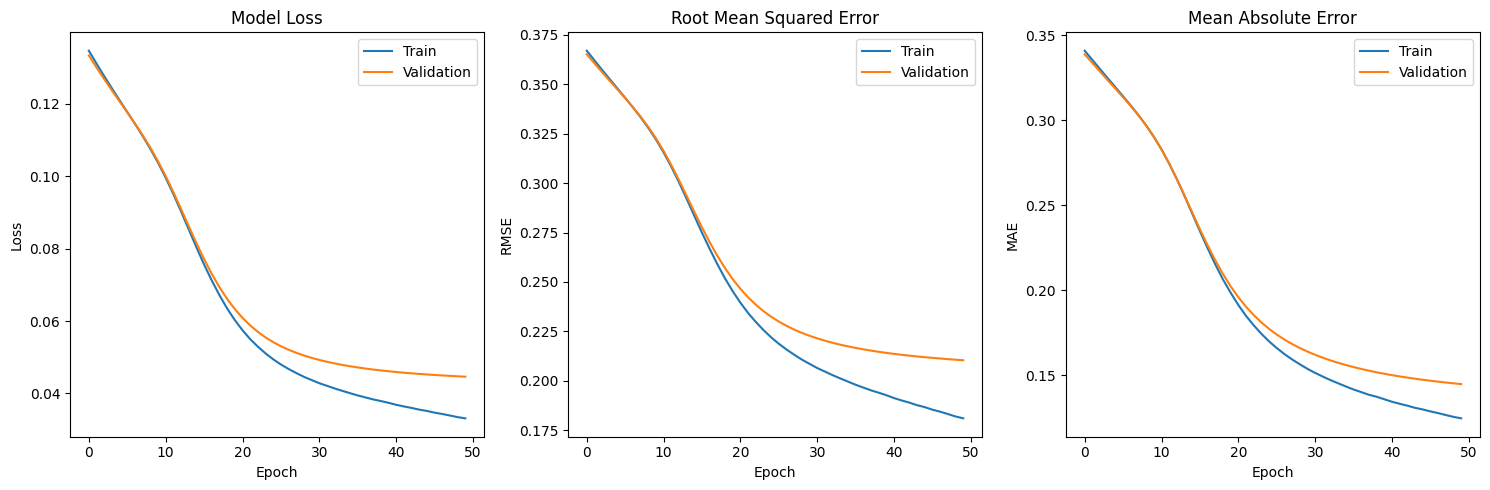

In [94]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 3, 2)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 3, 3)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


Fungsi **`get_recommendations`** memberikan **rekomendasi anime** untuk pengguna berdasarkan **model rekomendasi** yang sudah dilatih. Fungsi ini pertama memeriksa apakah **user\_id** ada dalam data, lalu mengambil anime yang sudah dinilai pengguna. Kemudian, fungsi menyaring anime yang belum dinilai dan mempersiapkan data untuk prediksi rating. Rating yang diprediksi dinormalisasi kembali ke skala asli dan diurutkan berdasarkan rating tertinggi. Fungsi mengembalikan **top\_k** anime teratas berdasarkan rating yang diprediksi.


In [95]:
def get_recommendations(user_id, model, user_to_idx, anime_to_idx,
                       idx_to_anime, ratings_subset, top_k=10):
    """
    Mendapatkan rekomendasi anime untuk user tertentu

    Args:
        user_id: ID user yang ingin diberi rekomendasi
        model: Model yang sudah ditraining
        user_to_idx: Dictionary mapping user_id ke index
        anime_to_idx: Dictionary mapping anime_id ke index
        idx_to_anime: Dictionary mapping index ke anime_id
        ratings_subset: DataFrame rating subset
        top_k: Jumlah rekomendasi yang diinginkan

    Returns:
        List of recommended anime_ids with predicted ratings
    """

    if user_id not in user_to_idx:
        print(f"User {user_id} tidak ditemukan dalam data training")
        return []

    user_idx = user_to_idx[user_id]

    # Ambil anime yang sudah dinilai user ini
    user_rated_animes = set(ratings_subset[ratings_subset['user_id'] == user_id]['anime_id'].values)

    # Buat list semua anime yang belum dinilai
    all_anime_ids = list(anime_to_idx.keys())
    unrated_animes = [anime_id for anime_id in all_anime_ids if anime_id not in user_rated_animes]

    if not unrated_animes:
        print(f"User {user_id} sudah menilai semua anime")
        return []

    # Siapkan input untuk prediksi
    user_anime_array = np.array([[user_idx, anime_to_idx[anime_id]] for anime_id in unrated_animes])

    # Prediksi rating
    predicted_ratings = model.predict(user_anime_array)

    # Denormalisasi rating kembali ke skala asli
    predicted_ratings_denorm = predicted_ratings.flatten() * (max_rating - min_rating) + min_rating

    # Gabungkan dengan anime_id dan sort berdasarkan rating tertinggi
    anime_ratings = list(zip(unrated_animes, predicted_ratings_denorm))
    anime_ratings.sort(key=lambda x: x[1], reverse=True)

    return anime_ratings[:top_k]

Fungsi **`display_recommendations`** menampilkan **top k** rekomendasi anime untuk **user\_id**, dengan format yang rapi. Fungsi ini menampilkan nama anime dan **predicted rating** jika **`anime_df`** tersedia, atau hanya **anime ID** jika tidak. Fungsi ini juga membuat **reverse mapping** dari **index** ke **anime\_id** untuk menampilkan nama anime dari rekomendasi.


In [96]:
def display_recommendations(user_id, recommendations, anime_df=None):
    """
    Menampilkan rekomendasi dengan format yang bagus
    """
    print(f"\n=== Top {len(recommendations)} Rekomendasi untuk User {user_id} ===")

    for i, (anime_id, predicted_rating) in enumerate(recommendations, 1):
        if anime_df is not None and 'name' in anime_df.columns:
            anime_name = anime_df[anime_df['anime_id'] == anime_id]['name'].iloc[0] if len(anime_df[anime_df['anime_id'] == anime_id]) > 0 else "Unknown"
            print(f"{i}. {anime_name} (ID: {anime_id}) - Predicted Rating: {predicted_rating:.2f}")
        else:
            print(f"{i}. Anime ID: {anime_id} - Predicted Rating: {predicted_rating:.2f}")

# Buat reverse mapping untuk rekomendasi
idx_to_anime = {idx: anime_id for anime_id, idx in anime_to_idx.items()}

Kode ini menguji sistem rekomendasi dengan **user ID pertama** dari **`sample_users`**. Pertama, beberapa rating pengguna ditampilkan, kemudian **10 rekomendasi anime** dihasilkan menggunakan **`get_recommendations`** dan ditampilkan dengan **`display_recommendations`**. Terakhir, kinerja model pada data validasi ditampilkan, mencakup **loss**, **RMSE**, dan **MAE** pada **validation set**.


In [97]:
print("\n" + "="*50)
print("TESTING SISTEM REKOMENDASI")
print("="*50)

# Ambil user ID pertama dari sample untuk testing
test_user_id = sample_users[0]
print(f"Testing dengan User ID: {test_user_id}")

# Tampilkan beberapa rating user ini
user_ratings = ratings_subset[ratings_subset['user_id'] == test_user_id][['anime_id', 'rating']].head()
print(f"\nBeberapa rating user ini:")
print(user_ratings)

# Generate rekomendasi
recommendations = get_recommendations(
    test_user_id,
    model,
    user_to_idx,
    anime_to_idx,
    idx_to_anime,
    ratings_subset,
    top_k=10
)

# Tampilkan rekomendasi
if recommendations:
    display_recommendations(test_user_id, recommendations, anime)
else:
    print("Tidak ada rekomendasi yang bisa diberikan")

print(f"\nModel performance pada validation set:")
print(f"Final validation loss: {min(history.history['val_loss']):.4f}")
print(f"Final validation RMSE: {min(history.history['val_root_mean_squared_error']):.4f}")
print(f"Final validation MAE: {min(history.history['val_mean_absolute_error']):.4f}")


TESTING SISTEM REKOMENDASI
Testing dengan User ID: 19797

Beberapa rating user ini:
         anime_id  rating
2044833      3002       9
2044834      6547       9
2044835      7054       8
2044836      8525       8
2044837      9253      10
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

=== Top 10 Rekomendasi untuk User 19797 ===
1. Fullmetal Alchemist: Brotherhood (ID: 5114) - Predicted Rating: 8.73
2. Mononoke Hime (ID: 164) - Predicted Rating: 8.28
3. Tengen Toppa Gurren Lagann (ID: 2001) - Predicted Rating: 8.27
4. Code Geass: Hangyaku no Lelouch R2 (ID: 2904) - Predicted Rating: 8.25
5. Howl no Ugoku Shiro (ID: 431) - Predicted Rating: 8.20
6. Sen to Chihiro no Kamikakushi (ID: 199) - Predicted Rating: 8.17
7. Clannad: After Story (ID: 4181) - Predicted Rating: 8.15
8. Death Note (ID: 1535) - Predicted Rating: 8.11
9. Code Geass: Hangyaku no Lelouch (ID: 1575) - Predicted Rating: 8.09
10. Hellsing Ultimate (ID: 777) - Predicted Rating: 8.05

Model performance pada validation set:
Final

Output ini menunjukkan hasil dari pengujian sistem rekomendasi untuk **User ID 19797**:

1. **Beberapa rating yang diberikan oleh pengguna**: Menampilkan anime yang telah dinilai oleh pengguna, dengan rating yang diberikan (misalnya, **anime ID 3002** diberi rating **9**).

2. **Top 10 rekomendasi anime**: Sistem memberikan rekomendasi berdasarkan prediksi rating yang dihitung model. Anime dengan **predicted rating** tertinggi ditampilkan pertama, seperti **Fullmetal Alchemist: Brotherhood** dengan prediksi rating **8.73**.

3. **Model performance pada validation set**:

   * **Final validation loss**: **0.0446**, yang menunjukkan kesalahan prediksi akhir model pada data validasi.
   * **Final validation RMSE**: **0.2104**, yang mengukur kesalahan rata-rata kuadrat pada data validasi. Semakin rendah nilai RMSE, semakin akurat model.
   * **Final validation MAE**: **0.1449**, yang menunjukkan kesalahan rata-rata absolut dalam prediksi model. Nilai yang lebih rendah menandakan model lebih akurat.

Secara keseluruhan, model berhasil memberikan rekomendasi yang relevan untuk pengguna, dengan kinerja yang baik pada data validasi (loss, RMSE, dan MAE yang rendah).
